# Download from links list (IMERG FINAL) 

This notebook will download all files from IMERG dataset via https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGHH_07/summary?keywords=%22IMERG%20final%22

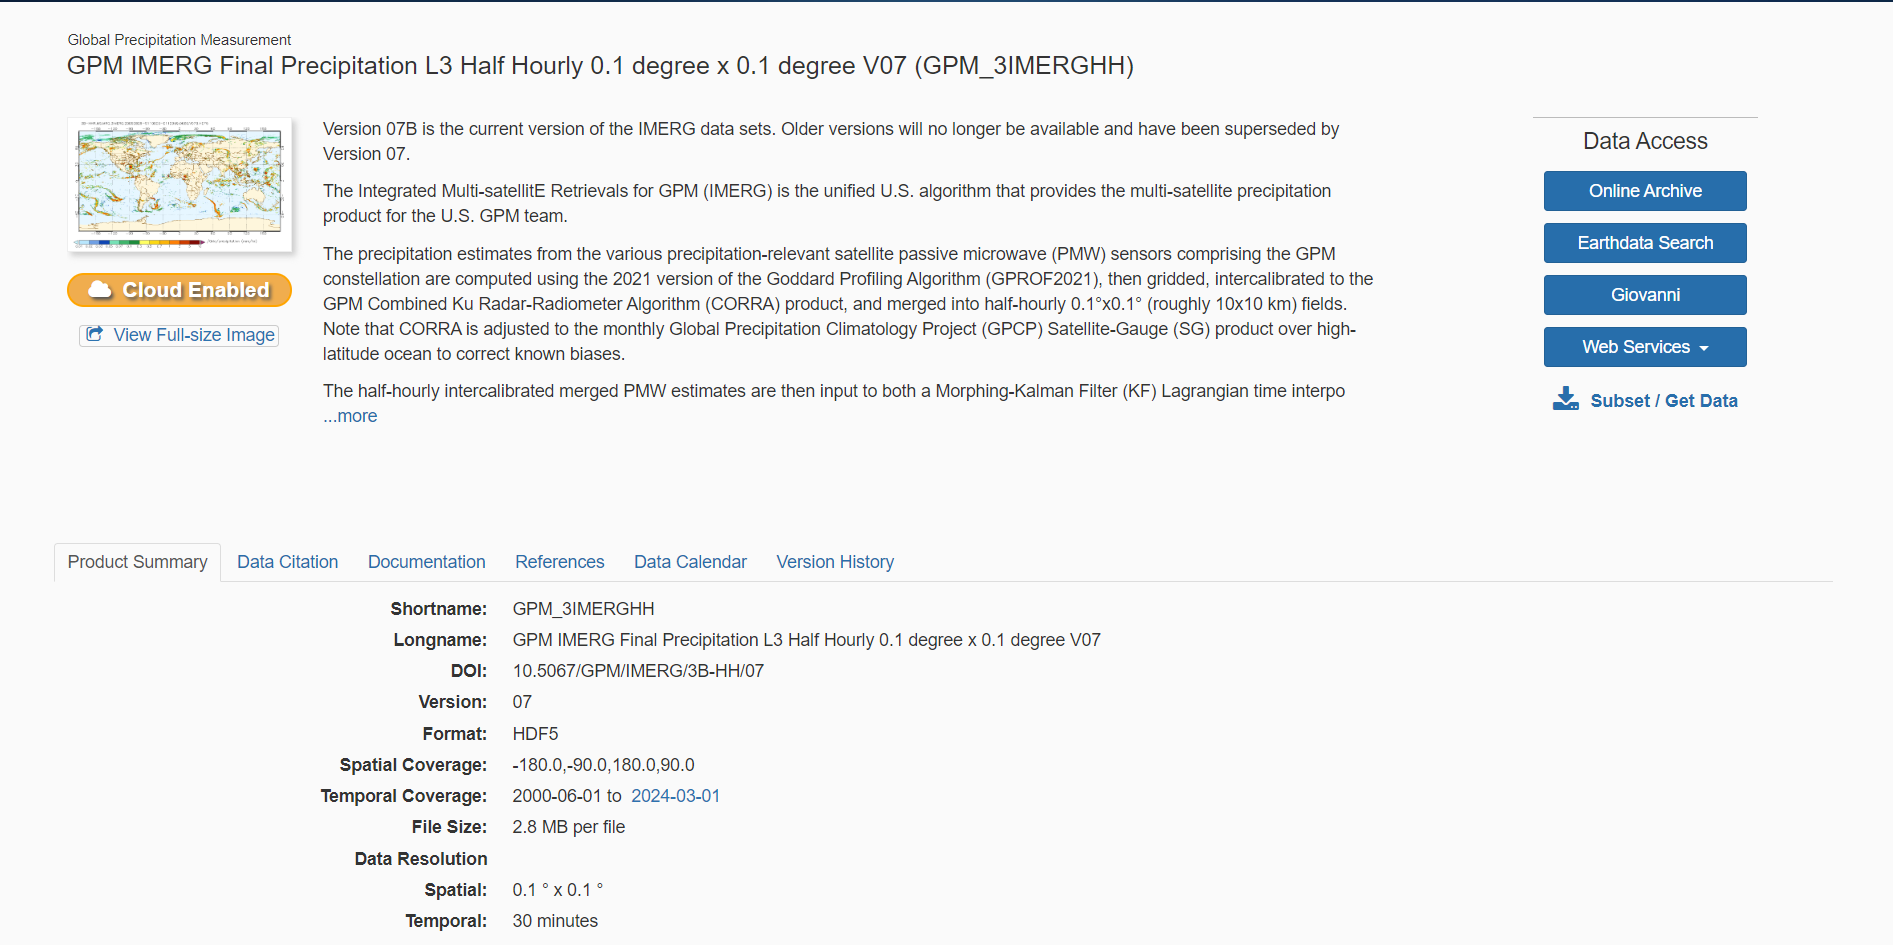

Setting up of API:
1) Create and Earthdata account https://disc.gsfc.nasa.gov/earthdata-login
2) Link and set permission for external access
3) To automate downloading using python, follow steps here https://disc.gsfc.nasa.gov/information/howto?keywords=python&title=How%20to%20Access%20GES%20DISC%20Data%20Using%20Python

## Main code block

This code block will download, renmane, merge, and compress individual 30-minutely into 1 month

Simply set the coordinates and time frame required on the website, download the links list and remove the first 2 lines from the notepad. The code will then download automatically.

In [ ]:
import os
import time
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import xarray as xr
from dask.diagnostics import ProgressBar
import netCDF4 as nc

# Define the base download directory
base_download_path = r"C:\Users\Jun Wei\Desktop\IMERG data files"
os.makedirs(base_download_path, exist_ok=True)

# Read the URLs from the text file
urls_file = r"c:\Users\Jun Wei\Downloads\subset_GPM_3IMERGHH_07_20240701_005823_.txt" #<--- Change this to the path of the text file containing the URLs
try:
    df = pd.read_csv(urls_file, header=None, delimiter="\t", on_bad_lines='warn')
    urls = df[0][:].tolist()
except Exception as e:
    print(f"Error reading URLs file: {e}")
    urls = []

# Function to get filenames and month directories from URLs
def get_filename_and_month_from_url(url):
    date_time_index = url.find("IMERG.")
    if date_time_index != -1:
        date_time_part = url[date_time_index+6:date_time_index+15] + url[date_time_index+16:date_time_index+20]
        filename = date_time_part + ".nc"
        month_dir = date_time_part[:6]
        return filename, month_dir
    else:
        return "unknown_date_time.nc", "unknown"

# Create a mapping of URLs to filenames and month directories
url_to_filename_and_month = {url: get_filename_and_month_from_url(url) for url in urls}

# Function to download a file
def download_file(session, url, filename, month_dir):
    month_path = os.path.join(base_download_path, month_dir)
    os.makedirs(month_path, exist_ok=True)
    filepath = os.path.join(month_path, filename)
    attempts = 0
    max_attempts = 3
    backoff_time = 1.5  # start with 1 second

    while attempts < max_attempts:
        try:
            res = session.get(url)
            res.raise_for_status()
            with open(filepath, 'wb') as f:
                f.write(res.content)
            return f"{filename} downloaded successfully to {month_dir}."
        except requests.exceptions.RequestException as e:
            attempts += 1
            if attempts < max_attempts:
                time.sleep(backoff_time)
                backoff_time *= 1  # exponential backoff
            else:
                return f"Failed to download {filename} after {attempts} attempts: {e}"
        except Exception as e:
            return f"Error saving {filename}: {e}"

# Set up the session with retries
session = requests.Session()
retry = Retry(total=5, backoff_factor=1, status_forcelist=[429, 500, 502, 503, 504])
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

# Download the files for a specific month
def download_files_for_month(month_dir, url_to_filename_and_month):
    month_urls = {url: (filename, md) for url, (filename, md) in url_to_filename_and_month.items() if md == month_dir}
    with ThreadPoolExecutor(max_workers=50) as executor:
        future_to_url = {executor.submit(download_file, session, url, filename, month_dir): url for url, (filename, _) in month_urls.items()}
        for future in as_completed(future_to_url):
            url = future_to_url[future]
            try:
                result = future.result()
                print(result)
            except Exception as e:
                print(f"Error downloading {url}: {e}")

# Check for missing files and redownload if necessary for a specific month
def check_and_redownload_for_month(month_dir, url_to_filename_and_month):
    month_path = os.path.join(base_download_path, month_dir)
    actual_files = os.listdir(month_path) if os.path.exists(month_path) else []
    
    # Identify missing files
    missing_files = [filename for url, (filename, md) in url_to_filename_and_month.items() if md == month_dir and filename not in actual_files]
    
    # If there are missing files, reconstruct their URLs and redownload them
    if missing_files:
        print(f"Retrying missing files for {month_dir}...")
        missing_url_to_filename_and_month = {url: (filename, md) for url, (filename, md) in url_to_filename_and_month.items() if filename in missing_files}
        download_files_for_month(month_dir, missing_url_to_filename_and_month)
    
    # Final check to ensure all files are downloaded
    actual_files = os.listdir(month_path) if os.path.exists(month_path) else []
    still_missing = [filename for url, (filename, md) in url_to_filename_and_month.items() if md == month_dir and filename not in actual_files]
    
    if still_missing:
        print(f"Some files are still missing in {month_dir}:")
        for filename in still_missing:
            print(filename)
    else:
        print(f"All files downloaded successfully for {month_dir}.")

# Combine files for a specific month
def combine_files_for_month(month_dir):
    month_path = os.path.join(base_download_path, month_dir)
    
    # List all .nc files in the month directory
    nc_files = [os.path.join(month_path, f) for f in os.listdir(month_path) if f.endswith('.nc')]
    
    # Sort the files to ensure they are in chronological order
    nc_files.sort()
    
    # Define the total number of files for progress tracking
    total_files = len(nc_files)
    print(f"Total number of files to combine for {month_dir}: {total_files}")

    try:
        # Open multiple files as a single xarray Dataset using dask
        combined_dataset = xr.open_mfdataset(nc_files, combine='by_coords', parallel=True, engine='netcdf4')

        # Define the output file path
        output_file = os.path.join(month_path, f"{month_dir}.nc")

        # Specify encoding to avoid OverflowError
        encoding = {}
        for var in combined_dataset.variables:
            if var == 'time':
                encoding[var] = {'dtype': 'int64'}
            else:
                if combined_dataset[var].dtype == 'int64':
                    encoding[var] = {'dtype': 'int32'}
                else:
                    encoding[var] = {}

        # Save the combined dataset to a new NetCDF file with progress tracking
        with ProgressBar():
            combined_dataset.to_netcdf(output_file, encoding=encoding, compute=True)

        print(f"Combined NetCDF file saved to {output_file}")

        # Compress the combined NetCDF file
        compress_netcdf(output_file)

    except Exception as e:
        print(f"Error combining NetCDF files for {month_dir}: {e}")

# Compress the NetCDF file
def compress_netcdf(file_path):
    # Open the source file (uncompressed)
    src_dataset = nc.Dataset(file_path, 'r')

    # Create a new compressed file
    compressed_file_path = file_path.replace('.nc', '_compressed.nc')
    dst_dataset = nc.Dataset(compressed_file_path, 'w', format='NETCDF4')

    # Copy global attributes
    for attr_name in src_dataset.ncattrs():
        dst_dataset.setncattr(attr_name, src_dataset.getncattr(attr_name))

    # Copy dimensions
    for dim_name, dim in src_dataset.dimensions.items():
        dst_dataset.createDimension(dim_name, len(dim) if not dim.isunlimited() else None)

    # Copy variables with enhanced compression settings
    for var_name, var in src_dataset.variables.items():
        # Create variable with compression settings
        dst_var = dst_dataset.createVariable(
            var_name, var.datatype, var.dimensions, 
            zlib=True, complevel=9, shuffle=True  # Set compression level to maximum (9) and enable shuffle
        )
        # Copy variable attributes
        dst_var.setncatts({attr: var.getncattr(attr) for attr in var.ncattrs()})
        # Copy variable data
        dst_var[:] = var[:]

    # Close the datasets
    src_dataset.close()
    dst_dataset.close()

    print(f'Compressed file created: {compressed_file_path}')

# Process each month
def process_months(url_to_filename_and_month):
    for month_dir in sorted(set(md for _, md in url_to_filename_and_month.values())):
        print(f"Processing month: {month_dir}")
        
        # Download files for the month
        download_files_for_month(month_dir, url_to_filename_and_month)
        
        # Check and redownload missing files
        check_and_redownload_for_month(month_dir, url_to_filename_and_month)

        # Combine files for the month
        combine_files_for_month(month_dir)

process_months(url_to_filename_and_month)


## Everything below here is just random code for debugging

This first block was used to download files then check which files are missing before downloading the missing files

In [ ]:
import os
import time
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

# Define the download directory
download_path = r"C:\Users\Jun Wei\Desktop\IMERG data files\2020-01-01\data files"
os.makedirs(download_path, exist_ok=True)

# Read the URLs from the text file
urls_file = r"c:\Users\Jun Wei\Downloads\subset_GPM_3IMERGHH_07_20240530_024229_.txt"
try:
    df = pd.read_csv(urls_file, header=None, delimiter="\t", on_bad_lines='warn')
    urls = df[0].tolist()
except Exception as e:
    print(f"Error reading URLs file: {e}")
    urls = []

# Function to get filenames from URLs
def get_filename_from_url(url):
    date_time_index = url.find("IMERG.")
    if date_time_index != -1:
        date_time_part = url[date_time_index+6:date_time_index+15] + url[date_time_index+16:date_time_index+20]
        return date_time_part + ".nc"
    else:
        return "unknown_date_time.nc"

# Create a mapping of URLs to filenames
url_to_filename = {url: get_filename_from_url(url) for url in urls}

# Function to download a file
def download_file(session, url, filename):
    filepath = os.path.join(download_path, filename)
    attempts = 0
    max_attempts = 3
    backoff_time = 1.5  # start with 1 second

    while attempts < max_attempts:
        try:
            res = session.get(url)
            res.raise_for_status()
            with open(filepath, 'wb') as f:
                f.write(res.content)
            return f"{filename} downloaded successfully."
        except requests.exceptions.RequestException as e:
            attempts += 1
            if attempts < max_attempts:
                time.sleep(backoff_time)
                backoff_time *= 1  # exponential backoff
            else:
                return f"Failed to download {filename} after {attempts} attempts: {e}"
        except Exception as e:
            return f"Error saving {filename}: {e}"

# Set up the session with retries
session = requests.Session()
retry = Retry(total=5, backoff_factor=1, status_forcelist=[429, 500, 502, 503, 504])
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

# Download the files initially
def download_files(url_to_filename):
    with ThreadPoolExecutor(max_workers=100) as executor:
        future_to_url = {executor.submit(download_file, session, url, filename): url for url, filename in url_to_filename.items()}
        for future in as_completed(future_to_url):
            url = future_to_url[future]
            try:
                result = future.result()
                print(result)
            except Exception as e:
                print(f"Error downloading {url}: {e}")

download_files(url_to_filename)

# Check for missing files and redownload if necessary
def check_and_redownload(url_to_filename):
    # List the actual downloaded files
    actual_files = os.listdir(download_path)
    
    # Identify missing files
    missing_files = [filename for filename in url_to_filename.values() if filename not in actual_files]
    
    # If there are missing files, reconstruct their URLs and redownload them
    if missing_files:
        print("Retrying missing files...")
        missing_url_to_filename = {url: filename for url, filename in url_to_filename.items() if filename in missing_files}
        download_files(missing_url_to_filename)
    
    # Final check to ensure all files are downloaded
    actual_files = os.listdir(download_path)
    still_missing = [filename for filename in url_to_filename.values() if filename not in actual_files]
    
    if still_missing:
        print("Some files are still missing:")
        for filename in still_missing:
            print(filename)
    else:
        print("All files downloaded successfully.")

check_and_redownload(url_to_filename)

Code to compress combined NC file

Saves space by chunking data and reducing overhead, however this means it might take slightly longer to run programn operations on the compressed file as the program has to recalculate everything.

In [ ]:
def compress_netcdf(file_path):
    # Open the source file (uncompressed)
    print("gayaf")
    print(file_path)
    src_dataset = nc.Dataset(file_path, 'r')
    print('gay')
    # Create a new compressed file
    compressed_file_path = file_path.replace('.nc', '_compressed.nc')
    print("gay2")
    dst_dataset = nc.Dataset(compressed_file_path, 'w', format='NETCDF4')

    # Copy global attributes
    for attr_name in src_dataset.ncattrs():
        dst_dataset.setncattr(attr_name, src_dataset.getncattr(attr_name))

    # Copy dimensions
    for dim_name, dim in src_dataset.dimensions.items():
        dst_dataset.createDimension(dim_name, len(dim) if not dim.isunlimited() else None)

    # Copy variables with enhanced compression settings
    for var_name, var in src_dataset.variables.items():
        # Create variable with compression settings
        dst_var = dst_dataset.createVariable(
            var_name, var.datatype, var.dimensions, 
            zlib=True, complevel=9, shuffle=True  # Set compression level to maximum (9) and enable shuffle
        )
        # Copy variable attributes
        dst_var.setncatts({attr: var.getncattr(attr) for attr in var.ncattrs()})
        # Copy variable data
        dst_var[:] = var[:]

    # Close the datasets
    src_dataset.close()
    dst_dataset.close()

    print(f'Compressed file created: {compressed_file_path}')

This code block does the following:
1) Checks whether there is a compressed file in the folder, if there is it means the folder is probably complete.
2) Checks if there are missing files in the folder, if there is, flag it in a missing list
3) Combine the files if all files are present
4) Compress

In [ ]:
import os
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
import sys
import netCDF4 as nc

# Define the directory containing the .nc files
data_dir = "e:\\IMERG\\2005\\200510"
missing = []

def merge_nc_files(data_dir):
    # List all .nc files in the directory
    nc_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.nc')]
    year_month = data_dir[-6:]
    compr = data_dir+"\\"+str(year_month)+"_compressed.nc"
    if compr in nc_files:
        print(f"NetCDF files already combined for {year_month}")
        return
    else:
        if len(nc_files) % 48 != 0:
            missing.append(year_month)
            return
        else:
            # Sort the files to ensure they are in chronological order
            nc_files.sort()
            print(nc_files)
            # Define the total number of files for progress tracking
            total_files = len(nc_files)
            print(f"Total number of files to combine: {total_files}")

            # Open multiple files as a single xarray Dataset using dask

            combined_dataset = xr.open_mfdataset(nc_files, combine='by_coords', parallel=True)

            output_name = year_month + ".nc"
            print(output_name)
            # Define the output file path
            output_file = os.path.join(data_dir, output_name)
            print(output_file)
            # Specify encoding to avoid OverflowError
            encoding = {}
            for var in combined_dataset.variables:
                if var == 'time':
                    encoding[var] = {'dtype': 'int64'}
                else:
                    if combined_dataset[var].dtype == 'int64':
                        encoding[var] = {'dtype': 'int32'}
                    else:
                        encoding[var] = {}

            # Save the combined dataset to a new NetCDF file with progress tracking
            with ProgressBar():
                combined_dataset.to_netcdf(output_file, encoding=encoding, compute=True)

            print(f"Combined NetCDF file saved to {output_file}")
            compress_netcdf(output_file)

folders = "E:\\IMERG"
for year in os.listdir(folders):
    year_folder = os.path.join(folders, year)
    for month in os.listdir(year_folder):
        month_folder = os.path.join(year_folder, month)
        merge_nc_files(month_folder)
print(missing)

In [ ]:
import os

folder_path = "E:\\IMERG"
error_folders = []
for year in os.listdir(folder_path):
    year_path = os.path.join(folder_path, year)
    for month in os.listdir(year_path):
        month_path = os.path.join(year_path, month)
        if len(os.listdir(month_path)) % 48 == 2:
            if os.path.exists(os.path.join(month_path, f"{month}.nc")) and os.path.exists(os.path.join(month_path, f"{month}_compressed.nc")):
                print(f"{month} ok!")
            else:
                error_folders.append(month)
        else:
            error_folders.append(month)
print(error_folders)


In [ ]:
import os
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
import sys
import netCDF4 as nc
def combine_files_for_month(month_dir):
    month_path = os.path.join(base_download_path, month_dir)
    print(month_path)
    # List all .nc files in the month directory
    nc_files = [os.path.join(month_path, f) for f in os.listdir(month_path) if f.endswith('.nc')]
    
    # Sort the files to ensure they are in chronological order
    nc_files.sort()
    
    # Define the total number of files for progress tracking
    total_files = len(nc_files)
    print(f"Total number of files to combine for {month_dir}: {total_files}")

    try:
        # Open multiple files as a single xarray Dataset using dask
        combined_dataset = xr.open_mfdataset(nc_files, combine='by_coords', parallel=True, engine='netcdf4')

        # Define the output file path
        output_file = os.path.join(month_path, f"{month_dir}.nc")

        # Specify encoding to avoid OverflowError
        encoding = {}
        for var in combined_dataset.variables:
            if var == 'time':
                encoding[var] = {'dtype': 'int64'}
            else:
                if combined_dataset[var].dtype == 'int64':
                    encoding[var] = {'dtype': 'int32'}
                else:
                    encoding[var] = {}

        # Save the combined dataset to a new NetCDF file with progress tracking
        with ProgressBar():
            combined_dataset.to_netcdf(output_file, encoding=encoding, compute=True)

        print(f"Combined NetCDF file saved to {output_file}")

        # Compress the combined NetCDF file
        compress_netcdf(output_file)

    except Exception as e:
        print(f"Error combining NetCDF files for {month_dir}: {e}")

# Compress the NetCDF file
def compress_netcdf(file_path):
    # Open the source file (uncompressed)
    print("gayaf")
    print(file_path)
    src_dataset = nc.Dataset(file_path, 'r')
    print('gay')
    # Create a new compressed file
    compressed_file_path = file_path.replace('.nc', '_compressed.nc')
    print("gay2")
    dst_dataset = nc.Dataset(compressed_file_path, 'w', format='NETCDF4')

    # Copy global attributes
    for attr_name in src_dataset.ncattrs():
        dst_dataset.setncattr(attr_name, src_dataset.getncattr(attr_name))

    # Copy dimensions
    for dim_name, dim in src_dataset.dimensions.items():
        dst_dataset.createDimension(dim_name, len(dim) if not dim.isunlimited() else None)

    # Copy variables with enhanced compression settings
    for var_name, var in src_dataset.variables.items():
        # Create variable with compression settings
        dst_var = dst_dataset.createVariable(
            var_name, var.datatype, var.dimensions, 
            zlib=True, complevel=9, shuffle=True  # Set compression level to maximum (9) and enable shuffle
        )
        # Copy variable attributes
        dst_var.setncatts({attr: var.getncattr(attr) for attr in var.ncattrs()})
        # Copy variable data
        dst_var[:] = var[:]

    # Close the datasets
    src_dataset.close()
    dst_dataset.close()

    print(f'Compressed file created: {compressed_file_path}')
# Define the directory containing the .nc files
base_download_path = r"e:\IMERG\2005"
for folder in os.listdir(base_download_path)[9:]:
    print(f"Processing {folder}")
    combine_files_for_month(folder)
    print(f"Processed {folder}")